<a href="https://colab.research.google.com/github/ChungbinKim/-/blob/master/summarization_local_ver03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Update summary
1. 실제 원문보다 대폭 길이를 줄인 준실제원문을 이용한 학습
    - 제1조 ~ 제4조와 같이 모든 이용약관에 공통적으로 포함되어 있는 조항들을 제거
    - 수정된 요약문
    
    
2. (계획) 지나치게 중복되는 단어들을 Vocab에서 제거하여 학습.
    - 가장 많이 등장하는 단어들이 요약문에 그대로 추출되는 문제가 있음.

### Environment Description

- CPU
    - name : Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz
    - cores : (using) 8
- GPU
    - NVIDIA GV102
- Memory
    - 16.0G

### Requirements

- Python : 3.8
- TensorFlow : 2.4

# Load Data

In [ ]:
import gc
import os
import shutil
import re
import json
import pickle
import glob
import pandas as pd
import numpy as np
import tqdm

In [ ]:
gc.enable()

In [ ]:
if os.path.exists('data'):
    pass
else:
    os.mkdir('data')

In [ ]:
# text 파일은 모두 data 폴더 아래에 있어야 합니다.

raw_dic = {}
sum_dic = {}
regex_id = '[0-9]+[_]'

for file in glob.glob('./data/*'):
    try:
        id_ = re.findall(regex_id, file)[0].replace('_', '')
        if '_raw2' in file:
            with open(file) as f:
                sentence = ' '.join([line for line in f.readlines()])
                raw_dic[id_] = sentence
        elif '_summary' in file:
            with open(file) as f:
                sentence = ' '.join([line for line in f.readlines()])
                sum_dic[id_] = sentence
    except:
        pass

#### (참고) data 전처리 시간을 줄이기 위해 모든 text(원문, 요약문)를 각각 하나의 pickle 파일로 저장

In [ ]:
# save for pickle format
with open('./data/raw2.pickle', 'wb') as f:
     pickle.dump(raw_dic, f)
    
with open('./data/summary.pickle', 'wb') as f:
     pickle.dump(sum_dic, f)

In [ ]:
#  load pickle format
with open('./data/raw2.pickle', 'rb') as f:
     raw_data = pickle.load(f)

with open('./data/summary.pickle', 'rb') as f:
     summary_data = pickle.load(f)

#### 원문, 요약문을 하나의 csv 파일로 저장

In [ ]:
raw_df = pd.DataFrame.from_dict(raw_dic, orient='index')
summary_df = pd.DataFrame.from_dict(sum_dic, orient='index')

In [ ]:
raw_data = pd.merge(raw_df, summary_df, left_index=True, right_index=True, how='inner').reset_index(drop=True)

In [ ]:
raw_data.columns=['raw_text', 'raw_summary']

ValueError: ignored

In [ ]:
raw_data.to_csv('data/raw_data.csv', index=False)

# Data Cleansing

### 한글 형태소 분석을 위해서 Konlpy 모듈 설치

- (참고) python 3.8 이상에서는 konlpy가 import 되지 않는 경우가 종종 있음.
- (해결방법_1) jpype1 모듈을 강제로 1.0.2 버전으로 다운그레이
- (해결방법_2) colab 환경에서 작업 ← **추천!**

In [ ]:
 !pip install konlpy

     |████████████████████████████████| 19.4MB 1.8MB/s 
     |████████████████████████████████| 460kB 30.0MB/s 
     |████████████████████████████████| 92kB 7.6MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
 !pip install jpype1==1.0.2

     |████████████████████████████████| 3.8MB 6.3MB/s 
  Found existing installation: JPype1 1.2.1
    Uninstalling JPype1-1.2.1:
      Successfully uninstalled JPype1-1.2.1


### Check vocab composition(word - frequency)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
raw_data = pd.read_csv('data/raw_data.csv')

In [ ]:
import re
from konlpy.tag import Okt, Twitter, Komoran
from matplotlib import pyplot as plt
from matplotlib import gridspec
import numpy as np

#### (참고) 확실한 명사를 추출하기 위해 가장 tag를 세밀하게 나눌 수 있는 Komoran 형태소 분석기 사용

In [ ]:
# okt = Okt()
# twt = Twitter()
komoran = Komoran()

#### (참고) 한국어 불용어 사전을 아래 링크로부터 참조하여 사용

In [ ]:
# stop words reference : https://www.ranks.nl/stopwords/korean
stop_words = []
with open('./k_stop_words.txt', 'r') as f:
    for word in f.readlines():
        stop_words.append(word.strip())

In [ ]:
def make_vocab(data):
    vocab = {}
    regex = re.compile('[^\d\w\b ]+')
    for sent in tqdm.tqdm(data):
        sentence = re.sub(regex, '', sent)
        for word, pos in komoran.pos(sentence):
            if word not in stop_words and pos in ('NNG', 'NNP'):
                try:
                    vocab[word] += 1
                except:
                    vocab[word] = 1
                    
    return sorted(vocab.items(),key=lambda x : x[1], reverse=True)

In [ ]:
raw_vocab = make_vocab(raw_data['raw_text'])
summary_vocab = make_vocab(raw_data['raw_summary'])

100%|██████████| 125/125 [00:01<00:00, 71.72it/s]


#### 원문, 요약문에서 등장하는 단어들의 누적 빈도수 - vocab

In [ ]:
raw_word_freq = np.array([v for _, v in raw_vocab])
summary_word_freq = np.array([v for _, v in summary_vocab])

### 200번 이상 등장한 단어는 제거

In [ ]:
stop_words2 = []
for i in np.where(raw_word_freq>=200)[0]:
    stop_words2.append(raw_vocab[i][0])

#### (참고) 원문 vocab 분포에서 상위 90% 빈도수의 위치 시각화

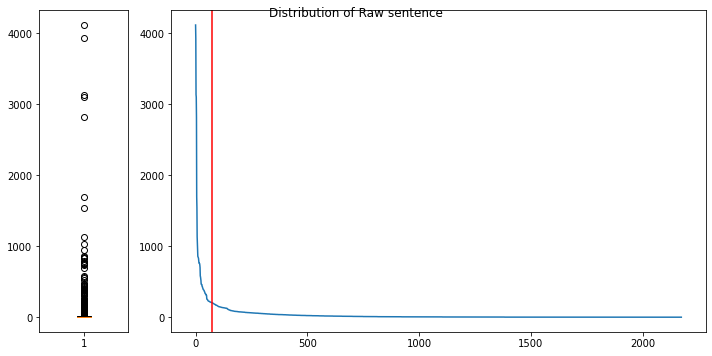

In [ ]:
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios':[2, 12]}, figsize=(10, 5))

ax[0].boxplot(raw_word_freq)
ax[1].plot(raw_word_freq)
ax[1].axvline(np.quantile(raw_word_freq, 0.9), color='red')
fig.suptitle('Distribution of Raw sentence')
fig.tight_layout()
plt.show()

### 전처리
- (1) stop_words : 한국어 불용어 사전
- (2) stop_words2 : 200번 이상 등장한 단어
- (3) 'NNG', 'NNP' : 일반명사, 고유명사


- **(1)과 (2)에 속하지 않으면서, (3)에 속하는 단어만 남긴 text**

In [ ]:
def preprocess_text(sentence):
    regex = re.compile('[^\d\w\b ]+')
    sentence = re.sub(regex, '', sentence)
    temp = []
    for word, pos in komoran.pos(sentence):
        if word not in stop_words and word not in stop_words2 and pos in ('NNG', 'NNP'):
            temp.append(word)
    return ' '.join(temp)

In [ ]:
data = pd.DataFrame()
data['Text'] = raw_data['raw_text'].apply(preprocess_text)
data['Summary'] = raw_data['raw_summary'].apply(preprocess_text)

#### (참고) Data cleansing 작업이 끝난 데이터를 pickle 로 저장

In [ ]:
 # save for pickle format
 #with open('./data/preprocessed_data.pickle', 'wb') as f:
   #  pickle.dump(data, f)

In [ ]:
# with open('./data/preprocessed_data.pickle', 'rb') as f:
#     data = pickle.load(f)

#### (참고) 원문과 요약문 길이에 대한 box plot

Text(0.5, 1.0, 'summary sentence')

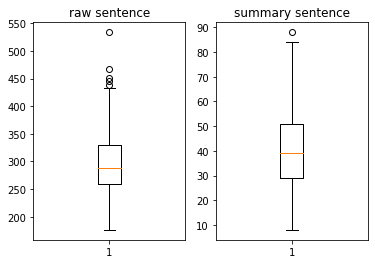

In [ ]:
plt.subplot(1,2,1)
plt.boxplot([len(sent.split()) for sent in data['Text']])
plt.title('raw sentence')
plt.subplot(1,2,2)
plt.boxplot([len(sent.split()) for sent in data['Summary']])
plt.title('summary sentence')

In [ ]:
sentence_max_len = 400
summary_max_len = 50

In [ ]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [ ]:
below_threshold_len(sentence_max_len, data['Text'])

전체 샘플 중 길이가 400 이하인 샘플의 비율: 0.92


In [ ]:
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.728


# Data Split

In [ ]:
from sklearn.model_selection import train_test_split

#### 학습 모델상의 Decoder에서 문장의 시작(sostoken)과 끝(eostoken)을 알리는 임의의 토큰 삽입

In [ ]:
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')

In [ ]:
X = data[['Text', 'decoder_input']]
y = data['decoder_target']

In [ ]:
# escape for OOM
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
encoder_input_train = X_train['Text']
decoder_input_train = X_train['decoder_input']
decoder_target_train = y_train

In [ ]:
encoder_input_test = X_test['Text']
decoder_input_test = X_test['decoder_input']
decoder_target_test = y_test

# Encoding

## Input encoding

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [ ]:
src_rare_cnt = 0
for key, value in src_tokenizer.word_counts.items():
    src_rare_cnt += 1
    if (value > 40):
        src_rare_cnt -= 1
        
print(src_rare_cnt)

1660


In [ ]:
src_vocab = src_rare_cnt - (src_rare_cnt % 100)
src_tokenizer = Tokenizer(num_words=src_vocab)
print('src_rare_cnt : %d' % src_vocab)

src_rare_cnt : 1600


In [ ]:
src_tokenizer.fit_on_texts(encoder_input_train)

In [ ]:
encoder_input_train  = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test  = src_tokenizer.texts_to_sequences(encoder_input_test)

## Target encoding

In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [ ]:
tar_rare_cnt = 0
for key, value in tar_tokenizer.word_counts.items():
    tar_rare_cnt += 1
    if (value > 40):
        tar_rare_cnt -= 1
        
print(tar_rare_cnt)

677


In [ ]:
tar_vocab = tar_rare_cnt - (tar_rare_cnt % 100)
tar_tokenizer = Tokenizer(num_words=tar_vocab)

In [ ]:
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [ ]:
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# Padding

In [ ]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = sentence_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = sentence_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

# Modeling

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## (선택) Single LSTM Encoder   vs   Multi LSTM Encoder

### Single LSTM Encoder

In [ ]:
embedding_dim = 64
hidden_size = 128

# 인코더
encoder_inputs = Input(shape=(sentence_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm1(enc_emb)

### Multi LSTM Encoder

In [ ]:
embedding_dim = 128
hidden_size = 256

# 인코더
with tf.device('/GPU:0'):
    encoder_inputs = Input(shape=(sentence_max_len,))

    # 인코더의 임베딩 층
    enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

    # 인코더의 LSTM 1
    encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
    encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

    # 인코더의 LSTM 2
    encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
    encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

    # 인코더의 LSTM 3
    encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
    encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [ ]:
# 디코더
with tf.device('/GPU:0'):
    decoder_inputs = Input(shape=(None,))

    # 디코더의 임베딩 층
    dec_emb_layer = Embedding(tar_vocab, embedding_dim)
    dec_emb = dec_emb_layer(decoder_inputs)

    # 디코더의 LSTM
    decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [ ]:
import urllib

### keras로 작성된 Attention layer 참조

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")

from attention import AttentionLayer

In [ ]:
# 어텐션 층(어텐션 함수)
with tf.device('/GPU:0'):
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

    # 어텐션의 결과와 디코더의 hidden state들을 연결
    decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

    # 디코더의 출력층
    decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
    decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 64)      102400      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     38400       input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 16, callbacks=[es], epochs = 100)

Epoch 1/100
7/7 [==============================] - 32s 3s/step - loss: 6.0979 - val_loss: 4.3610
Epoch 2/100
7/7 [==============================] - 13s 2s/step - loss: 4.9187 - val_loss: 4.2198
Epoch 3/100
7/7 [==============================] - 14s 2s/step - loss: 4.6977 - val_loss: 4.1159
Epoch 4/100
7/7 [==============================] - 14s 2s/step - loss: 4.5568 - val_loss: 4.0401
Epoch 5/100
7/7 [==============================] - 14s 2s/step - loss: 4.5741 - val_loss: 4.0131
Epoch 6/100
7/7 [==============================] - 14s 2s/step - loss: 4.4457 - val_loss: 3.9561
Epoch 7/100
7/7 [==============================] - 13s 2s/step - loss: 4.5011 - val_loss: 3.9716
Epoch 8/100
7/7 [==============================] - 13s 2s/step - loss: 4.4107 - val_loss: 3.9412
Epoch 9/100
7/7 [==============================] - 14s 2s/step - loss: 4.4043 - val_loss: 3.9149
Epoch 10/100
7/7 [==============================] - 13s 2s/step - loss: 4.2715 - val_loss: 3.8882
Epoch 11/100
7/7 [===========

In [ ]:
from matplotlib import pyplot as plt

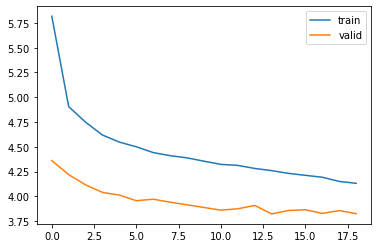

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [ ]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(sentence_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        # print(output_tokens)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # print(sampled_token_index)
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [ ]:
for i in range(0, 20):
    print("원문 : ",seq2text(encoder_input_test[i]) + '\n')
    print("실제 요약문 :",seq2summary(decoder_input_test[i])+ '\n')
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, sentence_max_len))+ '\n')
    print("\n")

원문 :  주소 주소 주소 유출 우려 사회 미풍양속 운영자 오인하 우려 주소 주소 도용 인지 안내 주소 전체 항의 갈음 금지 미풍양속 계속 안정 최선 노력 안전 신용정보 포함 보안 취급 방침 공시 준수 불만 피해 구제 요청 인력 구비 제기 의견 불만 인정 제기 의견 불만 게시판 활용 과정 결과 전달 안내 주의 준수 방해 상당 이유 기술상 일부 일자 전 초기 화면 무료 일부 정책 수정 보상 인정 거래 문 답변 제외 수신 거절 항의 전화 모사 기기 거래 문 회신 제외 화면 신한 수신 거절 저작자 귀속 검색 결과 프로모션 노출 노출 범위 일부 수정 복제 편집 저작권법 준수 센터 기능 공개 조치 이외 전화 팩스 통신망 저작권법 포함 권리자 요청 조치 전 권리자 요청 침해 인정 정책 임시 조치 귀속 지적 재산권 귀속 제휴 저작물 제외 조건 계정 주소 콘텐츠 포인트 부여 양도 판매 담보 처분 포인트 효율 후 포인트 일부 조정 포인트 주기 소멸 해제 초기 화면 센터 정보 관리 메뉴 취급 방침 보유 제외 데이터 소멸 작성 프로젝트 계정 일체 제작 공유 공용 게시판 후 탈퇴 정상 방해 경고 일시 정지 영구 정지 단계 전 결제 도용 저작권법 컴퓨터 프로그램 불법 프로그램 방해 통신망 불법 통신 해킹 악성 프로그램 배포 접속 초과 영구 정지 영구 정지 획득 포인트 혜택 소멸 보상 계속 로그인 하지 효율 천재지변 불가항력 면제 귀책사유 장애 사실 신뢰 준거 재판관 제기 소송 대한민국 준거 분쟁 소송 제소 당시 주소 주소 소 관할 지방법원 전속 관할 제소 당시 주소 소가 관할 법원 민사소송법 

실제 요약문 : 주소 주소 유출 우려 사회 미풍양속 운영자 오인하 우려 주소 안전 포함 보안 취급 방침 공시 준수 

예측 요약문 :  활동 활동 활동 영업 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 활동 

KeyError: ignored